In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [4]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [5]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experiental.set_memory_growth(physical_devices[0], True)
except:
  pass

# Build Data Loading Functions

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [41]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
      ret, frame = cap.read()
      frame = tf.image.rgb_to_grayscale(frame)
      frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [42]:
vocab = [x for x in "abcdefghijklmnopqsrtuvwxyz'?!123456789 "]

In [43]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The Vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size = {char_to_num.vocabulary_size()})"
)

The Vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 's', 'r', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size = 40)


In [44]:
def load_alignments(path:str) -> List[str]:
  with open(path, 'r') as f:
    lines = f.readlines()
  tokens = []
  for line in lines:
    line = line.split()
    if line[2] != 'sil':
      tokens = [*tokens, ' ', line[2]]
  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [48]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    # file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [46]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [49]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))
# 75 frames in length
# 46 pixels high
# 140 pixels wide
# 1 channel

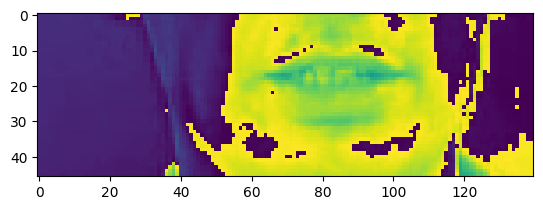

In [50]:
plt.imshow(frames[42])

In [20]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [37]:
from typing import Tuple
def mappable_function(path:str) -> Tuple[tf.Tensor, tf.Tensor]:
  result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
  return result

# Data Pipeline

In [23]:
from matplotlib import pyplot as plt

In [34]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [31]:
len(test)

50

In [51]:
frames, alignments = data.as_numpy_iterator().next()

UnknownError: ignored